# Exploratory Data Analysis for MovieLens-25M Dataset

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### Dimensions of datasets

In [2]:
movies = pd.read_csv('ml-25m/movies.csv')
ratings = pd.read_csv('ml-25m/ratings.csv')
tags = pd.read_csv('ml-25m/tags.csv')
links = pd.read_csv('ml-25m/links.csv')
genome_tags = pd.read_csv('ml-25m/genome-tags.csv')
genome_scores = pd.read_csv('ml-25m/genome-scores.csv')

print("Dimensions of datasets:")
print(f"Movies: {movies.shape}")
print(f"Ratings: {ratings.shape}")
print(f"Tags: {tags.shape}")
print(f"Links: {links.shape}")
print(f"Genome tags: {genome_tags.shape}")
print(f"Genome scores: {genome_scores.shape}")

Dimensions of datasets:
Movies: (62423, 3)
Ratings: (25000095, 4)
Tags: (1093360, 4)
Links: (62423, 3)
Genome tags: (1128, 2)
Genome scores: (15584448, 3)


### Movie Statistics

The first 5 films:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Movie dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None


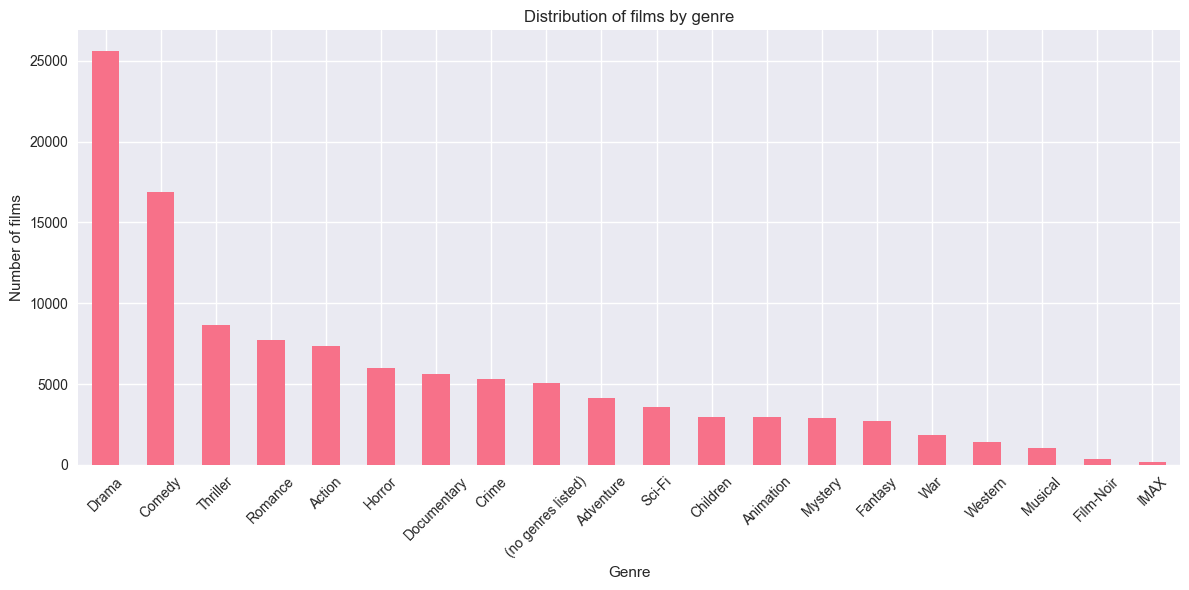

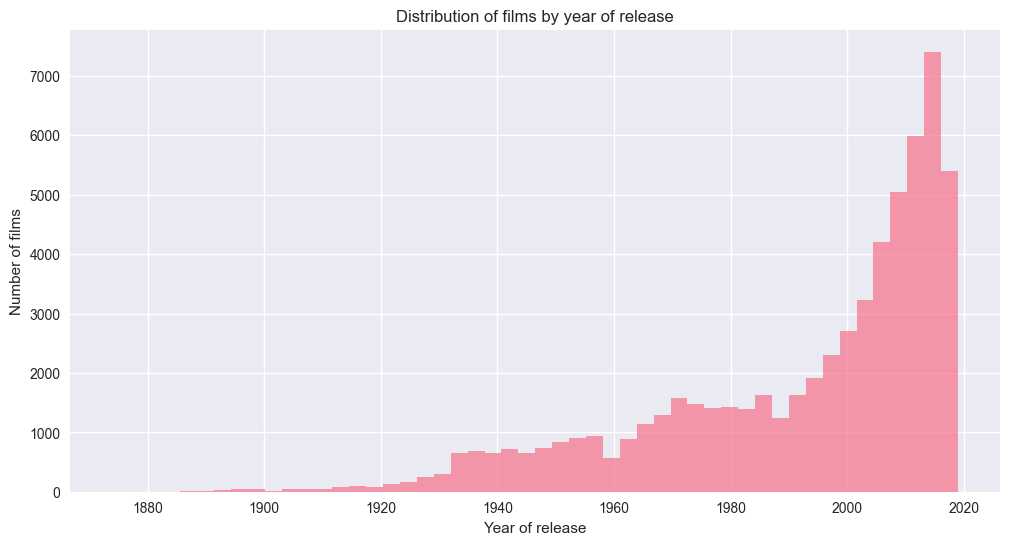

In [3]:
print("The first 5 films:")
print(movies.head())

print("\nMovie dataset Information:")
print(movies.info())


movies['genres_list'] = movies['genres'].str.split('|')
all_genres = [genre for sublist in movies['genres_list'].dropna() for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Distribution of films by genre')
plt.xlabel('Genre')
plt.ylabel('Number of films')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

plt.figure(figsize=(12, 6))
movies['year'].hist(bins=50, alpha=0.7)
plt.title('Distribution of films by year of release')
plt.xlabel('Year of release')
plt.ylabel('Number of films')
plt.show()

### Ratings Statistics

The first 5 ratings:
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510

Timestamp range: 1995-01-09 11:46:49 till 2019-11-21 09:15:03


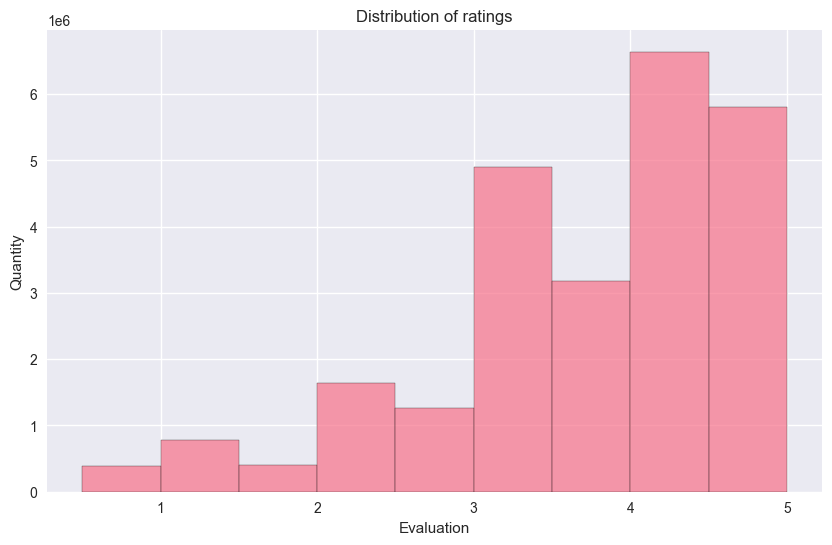

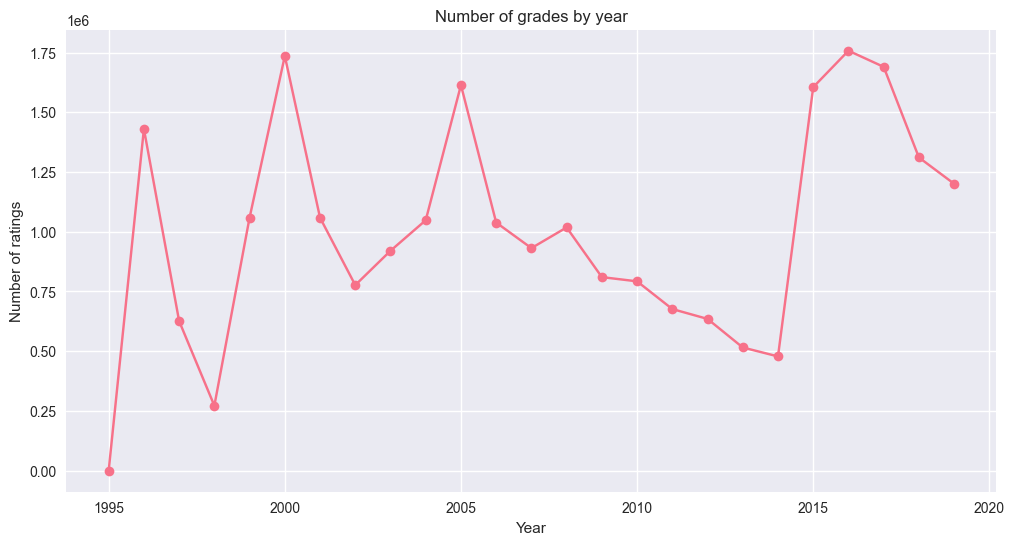

In [4]:
print("The first 5 ratings:")
print(ratings.head())

print(f"\nTimestamp range: {pd.to_datetime(ratings['timestamp'], unit='s').min()} till {pd.to_datetime(ratings['timestamp'], unit='s').max()}")

plt.figure(figsize=(10, 6))
ratings['rating'].hist(bins=9, alpha=0.7, edgecolor='black')
plt.title('Distribution of ratings')
plt.xlabel('Evaluation')
plt.ylabel('Quantity')
plt.xticks(range(1, 6))
plt.show()

ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['datetime'].dt.year
ratings['month'] = ratings['datetime'].dt.month

plt.figure(figsize=(12, 6))
ratings_per_year = ratings['year'].value_counts().sort_index()
ratings_per_year.plot(kind='line', marker='o')
plt.title('Number of grades by year')
plt.xlabel('Year')
plt.ylabel('Number of ratings')
plt.grid(True)
plt.show()

### Tag Statistics

Tag Statistics:
Total unique tags: 73050
Total tag applications: 1093360


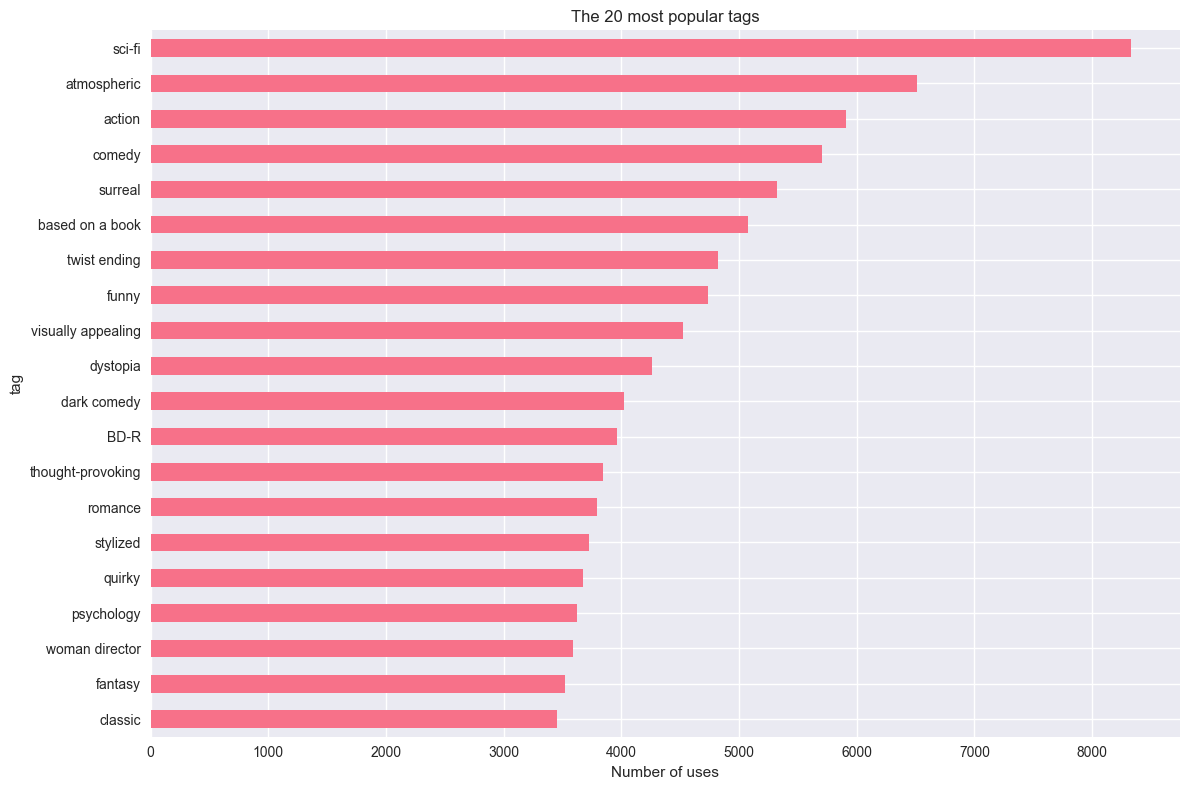

In [5]:
print("Tag Statistics:")
print(f"Total unique tags: {tags['tag'].nunique()}")
print(f"Total tag applications: {len(tags)}")

# Most popular tags
top_tags = tags['tag'].value_counts().head(20)

plt.figure(figsize=(12, 8))
top_tags.plot(kind='barh')
plt.title('The 20 most popular tags')
plt.xlabel('Number of uses')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Analyze by genres

User-movie matrix sparsity: 99.7395%
Correct average ratings by genre:
                genre  avg_rating  movie_count
0               Drama    3.178996        24465
1              Comedy    3.041878        16051
2            Thriller    2.944456         8330
3             Romance    3.147095         7305
4              Action    2.926390         6913
5              Horror    2.650740         5746
6         Documentary    3.382493         5453
7               Crime    3.092680         5024
8  (no genres listed)    3.048613         4568
9           Adventure    3.011600         3868


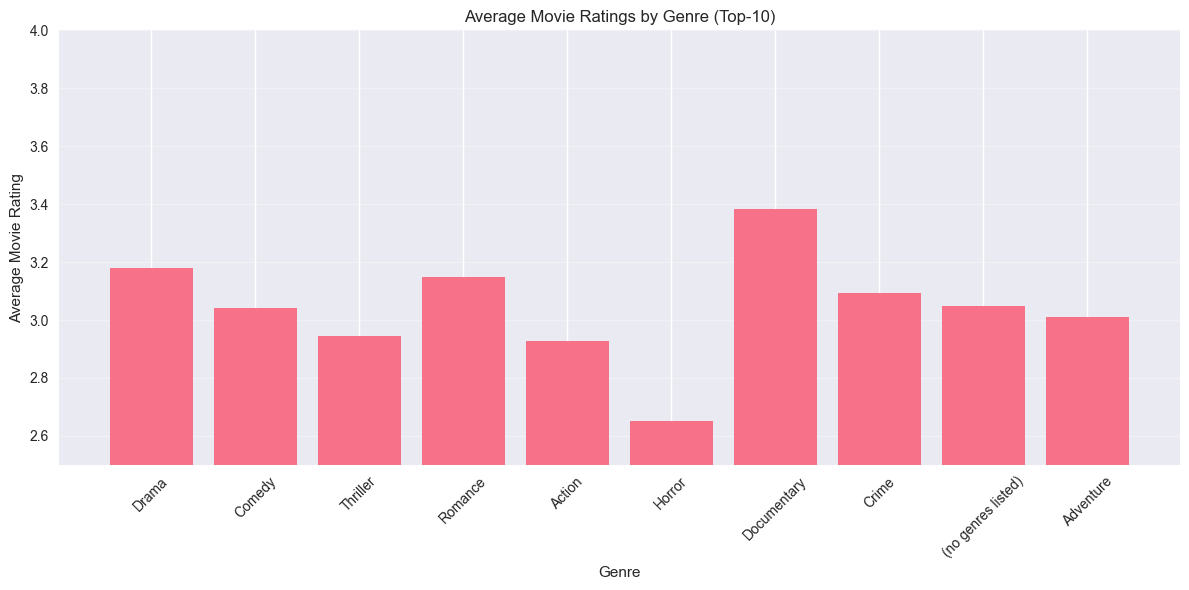

In [ ]:
# Ratings matrix (sparsity analysis)
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)

sparsity = 1 - (n_ratings / (n_users * n_movies))
print(f"User-movie matrix sparsity: {sparsity:.4%}")

# First calculate average rating for each movie
movie_avg_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
movie_avg_ratings.columns = ['movieId', 'avg_movie_rating']

# Then merge with genre information
movies_with_ratings = movies.merge(movie_avg_ratings, on='movieId')

genre_ratings_corrected = []
for genre in genre_counts.head(10).index:
    # Take movies of this genre
    genre_movies = movies_with_ratings[movies_with_ratings['genres'].str.contains(genre, na=False)]
    # Calculate average of movie average ratings
    genre_avg_rating = genre_movies['avg_movie_rating'].mean()
    genre_ratings_corrected.append((genre, genre_avg_rating, len(genre_movies)))

genre_ratings_corrected_df = pd.DataFrame(genre_ratings_corrected, 
                                         columns=['genre', 'avg_rating', 'movie_count'])

print("Correct average ratings by genre:")
print(genre_ratings_corrected_df)

# Build the plot
plt.figure(figsize=(12, 6))
plt.bar(genre_ratings_corrected_df['genre'], genre_ratings_corrected_df['avg_rating'])
plt.title('Average Movie Ratings by Genre (Top-10)')
plt.xlabel('Genre')
plt.ylabel('Average Movie Rating')
plt.xticks(rotation=45)
plt.ylim(2.5, 4.0)  # Expected range for MovieLens
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Monthly activity

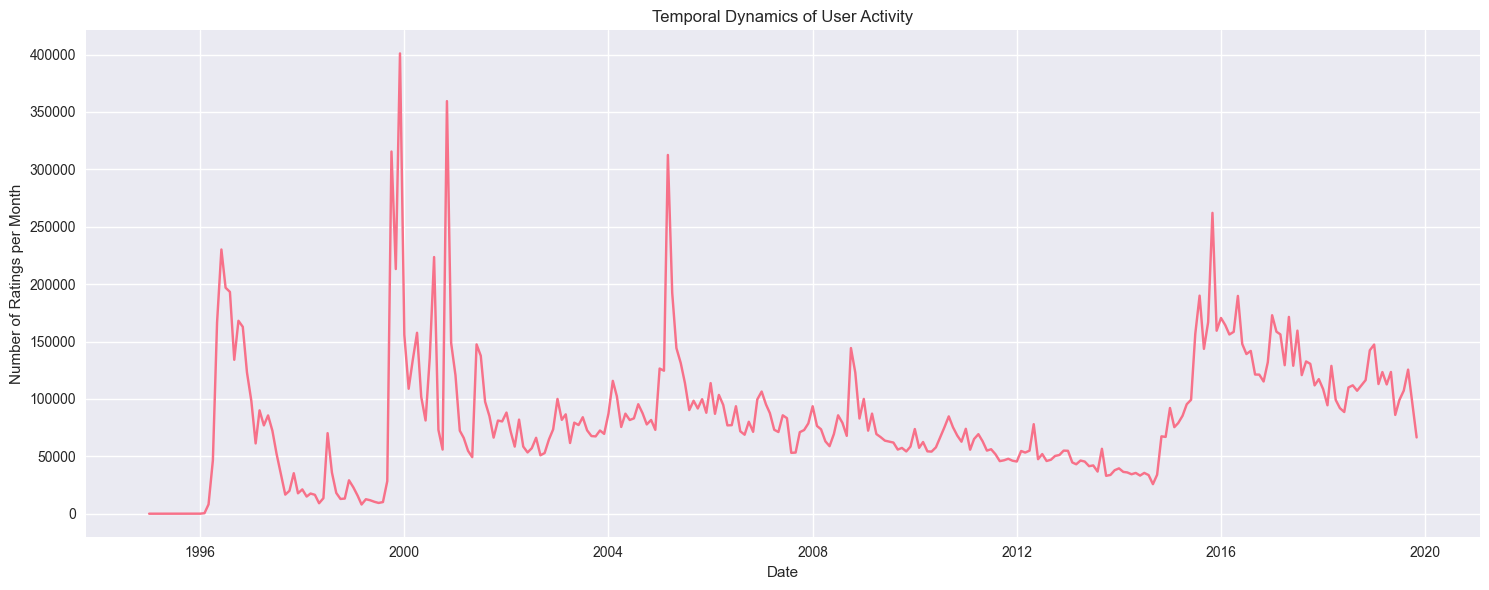

In [ ]:
monthly_activity = ratings.groupby(['year', 'month']).size().reset_index(name='count')
monthly_activity['date'] = pd.to_datetime(monthly_activity[['year', 'month']].assign(day=1))

plt.figure(figsize=(15, 6))
plt.plot(monthly_activity['date'], monthly_activity['count'])
plt.title('Temporal Dynamics of User Activity')
plt.xlabel('Date')
plt.ylabel('Number of Ratings per Month')
plt.grid(True)
plt.tight_layout()
plt.show()

### Summary table with key statistics

In [ ]:
summary_stats = {
    'Metric': [
        'Total Users',
        'Total Movies', 
        'Total Ratings',
        'Total Tags',
        'Total Genome Tags',
        'Matrix Sparsity',
        'Average Rating',
        'Data Period'
    ],
    'Value': [
        n_users,
        n_movies,
        n_ratings,
        tags['tag'].nunique(),
        genome_tags['tagId'].nunique(),
        f"{sparsity:.4%}",
        f"{ratings['rating'].mean():.2f}",
        f"{ratings['datetime'].min().date()} - {ratings['datetime'].max().date()}"
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("Dataset Summary Statistics:")
print(summary_df)

Dataset Summary Statistics:
              Metric                    Value
0        Total Users                   162541
1       Total Movies                    59047
2      Total Ratings                 25000095
3         Total Tags                    73050
4  Total Genome Tags                     1128
5    Matrix Sparsity                 99.7395%
6     Average Rating                     3.53
7        Data Period  1995-01-09 - 2019-11-21
